# 본 파일은 Agent RAG 구현
- 회의 6/5(목)

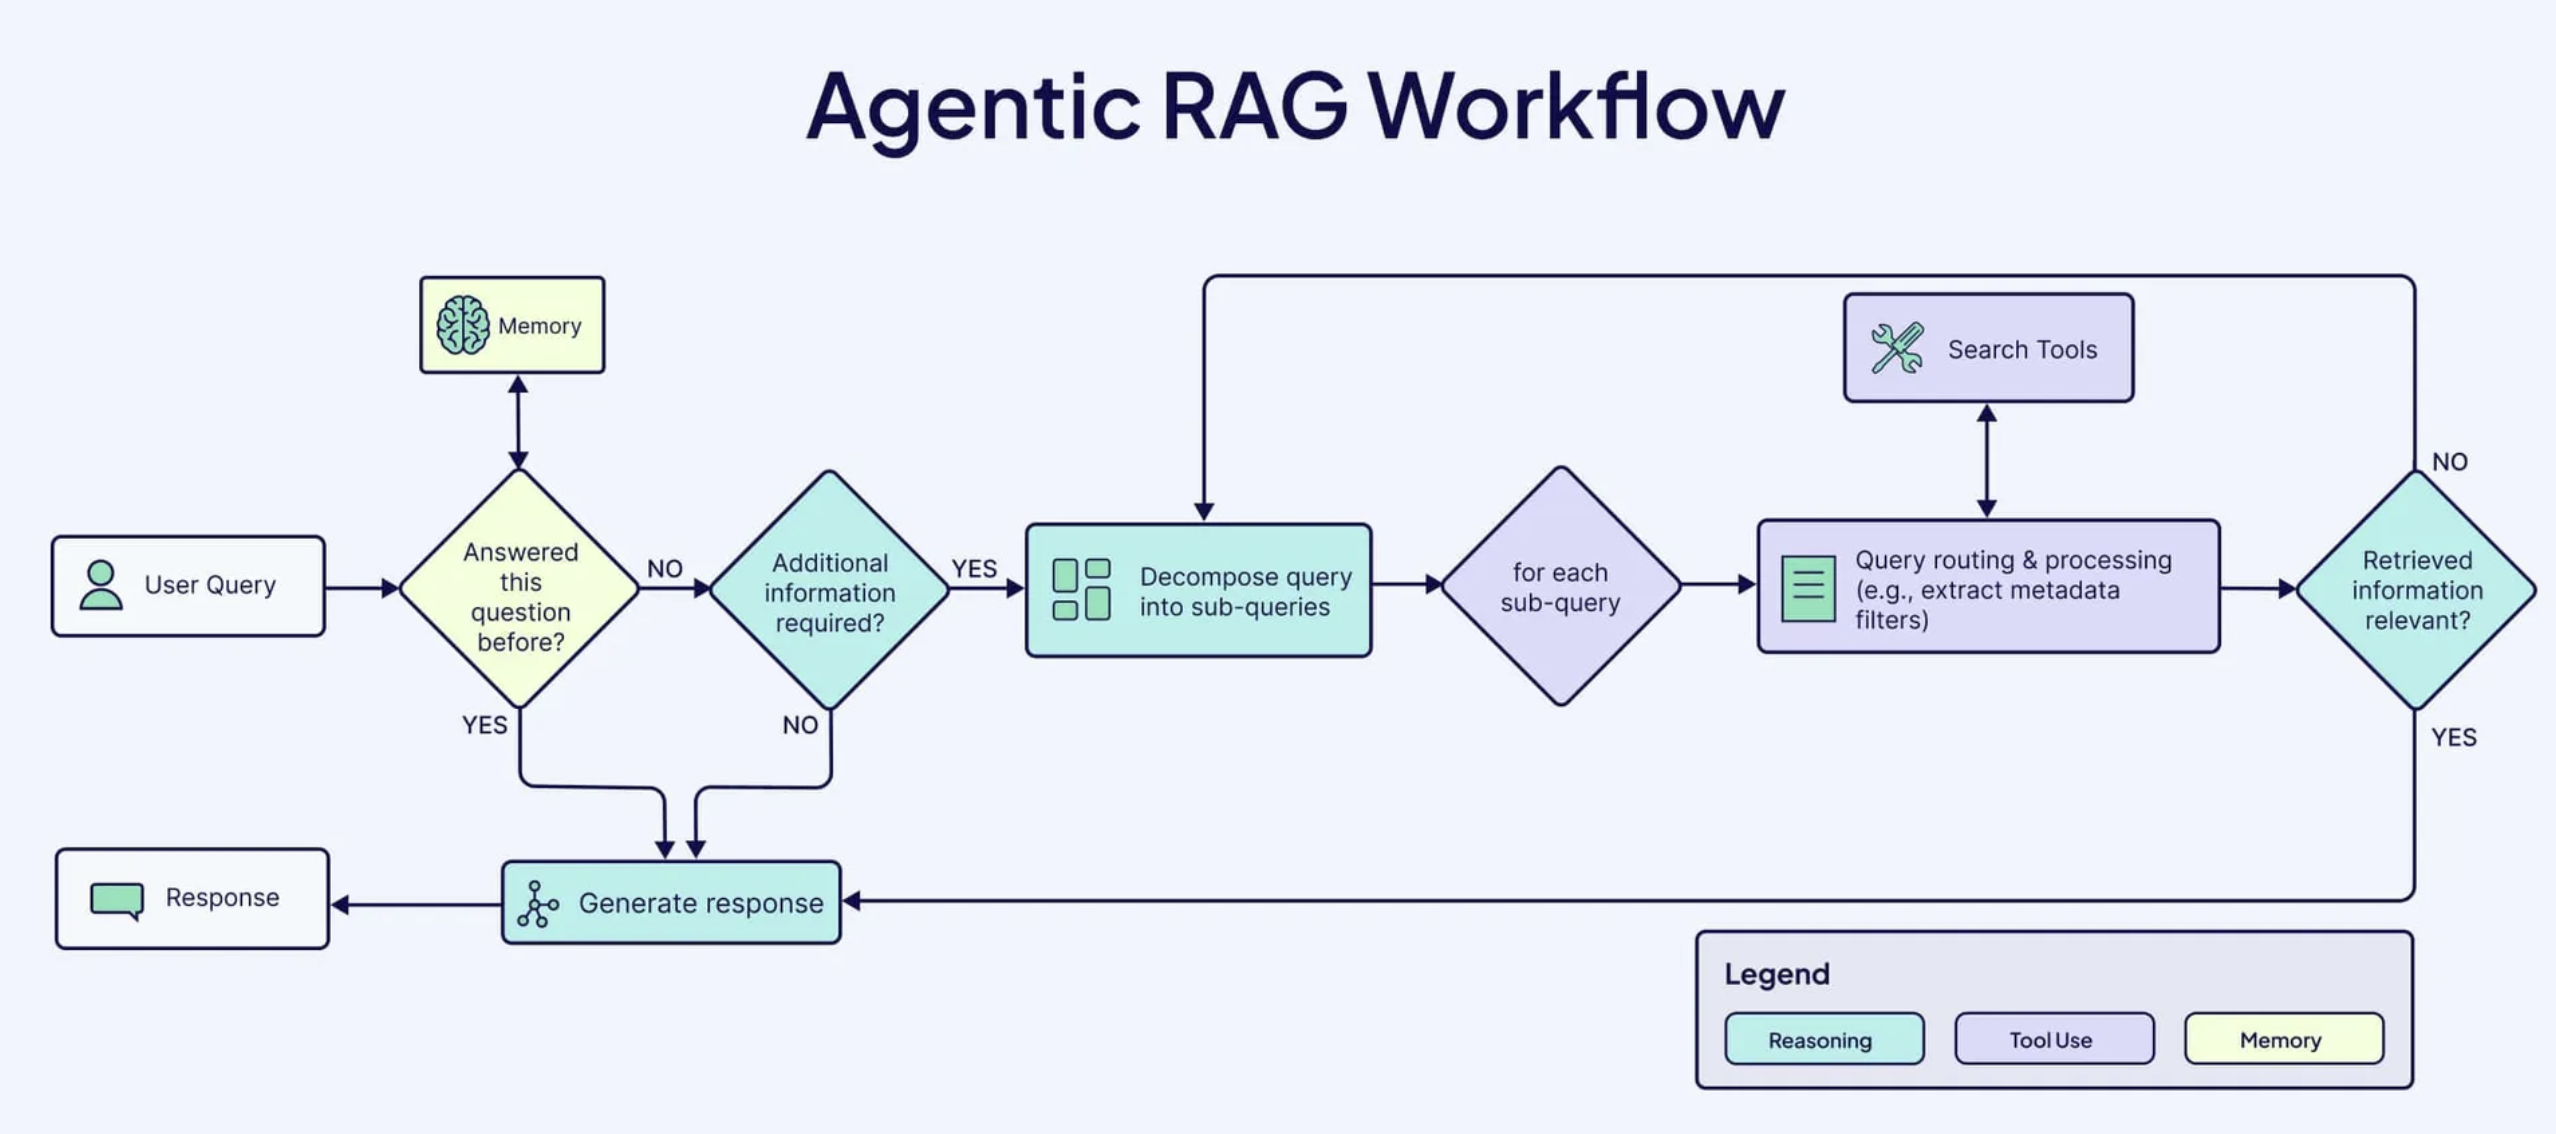

## 1) 먼저 neo4j 연결 여부 테스트
- https://python.langchain.com/docs/integrations/graphs/neo4j_cypher/#add-examples-in-the-cypher-generation-prompt

In [5]:
# Neo4j 연결 테스트

from langchain_community.graphs import Neo4jGraph
from langchain_neo4j import GraphCypherQAChain, Neo4jGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

# 연결 정보 입력
test_graph = Neo4jGraph(
    url="bolt://localhost:7687",  
    username="neo4j",
    password="123456789",  
    refresh_schema=False
)

chain = GraphCypherQAChain.from_llm(
    llm=ChatOpenAI(temperature=0, model="gpt-4o-mini"),
    graph=test_graph,
    verbose=True,
    validate_cypher=True,
    allow_dangerous_requests=True,
    return_intermediate_steps=True
)

chain.invoke({"query": "환아 A (생성)의 나이는?"})



> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: 이름)} {position: line: 1, column: 14, offset: 13} for query: "MATCH (a:환아 {이름: 'A'}) RETURN a.나이"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: 환아)} {position: line: 1, column: 10, offset:

Generated Cypher:
MATCH (a:환아 {이름: 'A'}) RETURN a.나이
Full Context:
[]

> Finished chain.


{'query': '환아 A (생성)의 나이는?',
 'result': '저는 그에 대한 정보를 알지 못합니다.',
 'intermediate_steps': [{'query': "MATCH (a:환아 {이름: 'A'}) RETURN a.나이"},
  {'context': []}]}

In [6]:
try:
    result = test_graph.query(
        'MATCH (p:Patient)-[:UNDERWENT]->(s:Surgery)-[:HAS_RESULT]->(r:Result) WHERE p.name CONTAINS "환아 A" RETURN s.name AS 수술명, r.description AS 수술후상태')
    print("연결 성공! 수술 결과:", result)
except Exception as e:
    print("연결 실패:", e)

# "MATCH (p:Patient)-[:UNDERWENT]->(s:Surgery)-[:HAS_RESULT]->(r:Result) "
# "WHERE p.name CONTAINS '환아 A' "
# "RETURN s.name AS 수술명, r.description AS 수술후상태"

연결 성공! 수술 결과: [{'수술명': '오른손 합지증 분리술', '수술후상태': '발관 직전 기도 분비물로 인한 천명음 있었으나 제거 후 상태 호전되어 완전히 각성된 상태에서 발관, 7일 후 퇴원'}]


## 2) 기본적인 Agent RAG 흐름 구현

<기본 흐름>
- 질문 
- -> Agent 
- -> 총 세 개의 함수(환자 DB 검색 / 의학 자료 검색(벡터 DB) / 이메일 전송 여부) 중에서 필요한 함수를 Agent가 질문을 보고 스스로 선택
- -> 선택된 함수를 호출해 명령을 수행후 결과 반환

<필요한 노드>
- sub query 노드
- MCP 연결
- 메일 작성한 것을 사람이 개입해서 체크하는 노드 (human-in-the-loop)

In [ ]:
from langchain_community.graphs import Neo4jGraph
from langchain.prompts import PromptTemplate
import os
from dotenv import load_dotenv
from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage
import json
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from openai import OpenAI

load_dotenv()

# Neo4j 연결
neo4j_graph = Neo4jGraph(
    url="bolt://localhost:7687",  
    username="neo4j",
    password="123456789",  
    refresh_schema=False)

# LLM 정의 (OpenAI 사용 예시)
llm = ChatOpenAI(model="gpt-4o-mini", 
                 temperature=0.3)

# GraphState 상태 정의
class ChatbotState(TypedDict):
    question: Annotated[str, "Question"] 
    neo4j_data: Annotated[List, "Context"]  
    vector_data: Annotated[List, "Context"]  
    answer: Annotated[str, "Answer"]  
    messages: Annotated[List, add_messages]  
    tools : Annotated[List,"tool"]

# 질문을 Cypher로 변환 함수 후 검색된 값 리턴
def change_query_to_cypher(state: ChatbotState):

    CYPHER_GENERATION_TEMPLATE = PromptTemplate.from_template("""
# Task:
Generate a Cypher query to answer the user's question using the provided graph schema.

# Guidelines:
- Use only the relationship types and node properties defined in the schema.
- Use MATCH and RETURN clauses to extract only the necessary properties.
- Always filter using WHERE clauses with node properties when appropriate (e.g., p.name CONTAINS "xxx").
- If the question expects a count or number, use count(*) with an alias.
- If descriptive fields are expected, use RETURN ... AS [Korean field name] style.
- Avoid returning full nodes unless explicitly requested.
- If the question refers to information not present in the schema, respond with: `UNSUPPORTED_QUERY`

# Schema (Node:Label and Relationship):
(:Patient)-[:UNDERWENT]->(:Surgery)
(:Surgery)-[:HAS_SYMPTOM]->(:Symptom)
(:Surgery)-[:HAS_PROCEDURE]->(:Procedure)
(:Surgery)-[:HAS_RESULT]->(:Result)
(:Surgery)-[:HAS_NOTE]->(:Note)

# Examples:
Question: How many surgeries has Patient A undergone?
MATCH (p:Patient)-[:UNDERWENT]->(s:Surgery) WHERE p.name CONTAINS  "Patient A" RETURN count(s) AS 수술횟수

Question: What is the result of 환아 B's surgery?
MATCH (p:Patient)-[:UNDERWENT]->(s:Surgery)-[:HAS_RESULT]->(r:Result) WHERE p.name CONTAINS  "환아 B" RETURN s.name AS 수술명, r.description AS 수술후상태
# User's Question:
{question}
""")
    
    query = state["question"]
    
    CYPHER_GENERATION_PROMPT = CYPHER_GENERATION_TEMPLATE.format(question=query)

    cypher_query = llm.invoke(CYPHER_GENERATION_PROMPT)

    if isinstance(cypher_query, AIMessage):
        response_text = cypher_query.content
    else:
        response_text = str(cypher_query)

    data = neo4j_graph.query(response_text)

    return ChatbotState(neo4j_data=[json.dumps(data, ensure_ascii=False)])

# 그래프 db 데이터를 기반으로 답변 생성
def generate_cypher_to_answer(state: ChatbotState):

    prompt = PromptTemplate.from_template("""You are a helpful assistant for medical patient queries.
                Based on the data below from the knowledge graph, answer the user's question.

                Question: {question}

                Graph Results:{results}

                Answer:
                """)
    
    query = state["question"]
    docs = state['documents']
    
    formatted_prompt = prompt.format(question = query, results = docs)

    response = llm.invoke(formatted_prompt) 

    if isinstance(response, AIMessage):
        response_text = response.content
    else:
        response_text = str(response)

    return ChatbotState(answer=response_text,
                        messages=[HumanMessage(content=query),AIMessage(content=response_text)])


# vector db에서 문서 검색하는 노드
def retrieve_vector_db(state:ChatbotState):

    query = state["question"]
    
    edit_path = "./edit_db"
    
    load_edit_db = Chroma(persist_directory=edit_path,
                        embedding_function=OpenAIEmbeddings(model="text-embedding-3-large"),
                        collection_name="edit")
    
    reranker_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
    compressor_retriever = CrossEncoderReranker(model=reranker_model, 
                                                top_n=5)
    
    edit_db_retriever = load_edit_db.as_retriever(search_kwargs={"k": 10})
    edit_retriever = ContextualCompressionRetriever(base_retriever=edit_db_retriever, 
                                                    base_compressor=compressor_retriever)
    
    docs = edit_retriever.invoke(query)

    return ChatbotState(vector_data = docs)

# 벡터 db에서 검색된 내용을 바탕으로 답변 생성
def generate_answer(state:ChatbotState):

    query = state["question"]
    docs = state['vector_data']

    prompt = PromptTemplate.from_template("""You are a helpful assistant for medical patient queries.
                Based on the data below from the knowledge graph, answer the user’s question accurately and concisely.
                Only use the information retrieved — do not add any extra or speculative content.

                User’s Question:
                {user_question}

                Retrieved Documents:
                {retrieved_content}

                Your Response:

                """)
    
    formatted_prompt = prompt.format(user_question = query, retrieved_content = docs)

    response = llm.invoke(formatted_prompt) 

    if isinstance(response, AIMessage):
        response_text = response.content
    else:
        response_text = str(response)

    return ChatbotState(answer=response_text,
                        messages=[HumanMessage(content=query),AIMessage(content=response_text)])

# 이메일 보내는 노드
def send_email():
    print("00 간호사한테 이메일 보내겠습니다!")

# tool(함수) 목록 정의
tools = [
    {
        "type": "function",
        "function": {
            "name": "change_query_to_cypher",
            "description": "환자의 정보를 찾기 위해 그래프 DB에서 검색하는 함수입니다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "name": {
                        "type": "string",
                        "description": "Patient name, e.g., 환아 A"
                    }
                },
                "required": ["name"],
                "additionalProperties": False
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "retrieve_vector_db",
            "description": "의학 정보를 Chroma Vector DB에서 검색하는 함수입니다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "Query, e.g., 혈소판감소증의 주된 원인은 무엇인가요?"
                    }
                },
                "required": ["query"],
                "additionalProperties": False
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "send_email",
            "description": "이메일을 보내는 함수입니다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "Query, e.g., 간호사1한테 이메일좀 보내줘."
                    }
                },
                "required": ["query"],
                "additionalProperties": False
            }
        }
    }
]

client = OpenAI()
# 어떤 함수를 호출할지 결정하는 에이전트
def agent_llm(state:ChatbotState):

    query = state["question"]

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=query,
        tools=tools,
        tool_choice="auto",               
        parallel_tool_calls=True)

    assistant_message = completion.choices[0].message
    tool_calls = assistant_message.tool_calls

    tools = []
    for tool_call in tool_calls:
        function_name = tool_call.function.name
        tools.append(function_name)
        function_args = json.loads(tool_call.function.arguments)

    return ChatbotState(tools=tools)

# 최종 선택된 노드들의 결과값을 합치는 LLM
def aggregate_node(state:ChatbotState):

    tool_list = state['tools']

    




    return

# 그래프 정의
builder = StateGraph(ChatbotState)

# 노드 정의
builder.add_node("change_query_to_cypher", change_query_to_cypher)
builder.add_node("generate_cypher_to_answer", generate_cypher_to_answer)
builder.add_node("retrieve_vector_db", retrieve_vector_db)
builder.add_node("generate_answer", generate_answer)
builder.add_node("send_mail", send_email)
builder.add_node("aggregate_node" , aggregate_node)
builder.add_node("agent_llm", agent_llm)

# 노드 연결
builder.add_edge(START, "agent_llm")
builder.add_edge()

builder.add_edge("change_query_to_cypher", "generate_cypher_to_answer")
builder.add_edge("retrieve_vector_db", "generate_answer")
builder.add_edge("agent_llm", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


In [73]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id" : "1"})
question = "환자 A의 나이는?"

for event in graph.stream(ChatbotState(question=question), config=config):
    print(event)

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'UNSUPPORTED_QUERY': expected 'FOREACH', 'ALTER', 'ORDER BY', 'CALL', 'USING PERIODIC COMMIT', 'CREATE', 'LOAD CSV', 'START DATABASE', 'STOP DATABASE', 'DEALLOCATE', 'DELETE', 'DENY', 'DETACH', 'DROP', 'DRYRUN', 'FINISH', 'GRANT', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OFFSET', 'OPTIONAL', 'REALLOCATE', 'REMOVE', 'RENAME', 'RETURN', 'REVOKE', 'ENABLE SERVER', 'SET', 'SHOW', 'SKIP', 'TERMINATE', 'UNWIND', 'USE' or 'WITH' (line 1, column 1 (offset: 0))
"UNSUPPORTED_QUERY"
 ^}

In [3]:
from langchain_community.graphs import Neo4jGraph
from langchain.prompts import PromptTemplate
import os
from dotenv import load_dotenv
from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage
import json
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from openai import OpenAI
from langchain.chat_models import ChatOpenAI

load_dotenv()

# Neo4j 연결
neo4j_graph = Neo4jGraph(
    url="bolt://localhost:7687",  
    username="neo4j",
    password="123456789",  
    refresh_schema=False)

# LLM 정의 (OpenAI 사용 예시)
llm = ChatOpenAI(model="gpt-4o-mini", 
                 temperature=0.3)

# GraphState 상태 정의
class ChatbotState(TypedDict):
    question: Annotated[str, "Question"] 
    neo4j_data: Annotated[List, "Context"]  
    vector_data: Annotated[List, "Context"]  
    answer: Annotated[str, "Answer"]  
    messages: Annotated[List, add_messages]  
    tools : Annotated[List,"tool"]

# 질문을 Cypher로 변환 함수 후 검색된 값 리턴
def change_query_to_cypher(state: ChatbotState):

    CYPHER_GENERATION_TEMPLATE = PromptTemplate.from_template("""
# Task:
Generate a Cypher query to answer the user's question using the provided graph schema.

# Guidelines:
- Use only the relationship types and node properties defined in the schema.
- Use MATCH and RETURN clauses to extract only the necessary properties.
- Always filter using WHERE clauses with node properties when appropriate (e.g., p.name CONTAINS "xxx").
- If the question expects a count or number, use count(*) with an alias.
- If descriptive fields are expected, use RETURN ... AS [Korean field name] style.
- Avoid returning full nodes unless explicitly requested.
- If the question refers to information not present in the schema, respond with: `UNSUPPORTED_QUERY`

# Schema (Node:Label and Relationship):
(:Patient)-[:UNDERWENT]->(:Surgery)
(:Surgery)-[:HAS_SYMPTOM]->(:Symptom)
(:Surgery)-[:HAS_PROCEDURE]->(:Procedure)
(:Surgery)-[:HAS_RESULT]->(:Result)
(:Surgery)-[:HAS_NOTE]->(:Note)

# Examples:
Question: How many surgeries has Patient A undergone?
MATCH (p:Patient)-[:UNDERWENT]->(s:Surgery) WHERE p.name CONTAINS  "Patient A" RETURN count(s) AS 수술횟수

Question: What is the result of 환아 B's surgery?
MATCH (p:Patient)-[:UNDERWENT]->(s:Surgery)-[:HAS_RESULT]->(r:Result) WHERE p.name CONTAINS  "환아 B" RETURN s.name AS 수술명, r.description AS 수술후상태
# User's Question:
{question}
""")
    
    query = state["question"]
    
    CYPHER_GENERATION_PROMPT = CYPHER_GENERATION_TEMPLATE.format(question=query)

    cypher_query = llm.invoke(CYPHER_GENERATION_PROMPT)

    if isinstance(cypher_query, AIMessage):
        response_text = cypher_query.content
    else:
        response_text = str(cypher_query)

    data = neo4j_graph.query(response_text)

    return ChatbotState(neo4j_data=[json.dumps(data, ensure_ascii=False)])

# 그래프 db 데이터를 기반으로 답변 생성
def generate_cypher_to_answer(state: ChatbotState):

    prompt = PromptTemplate.from_template("""You are a helpful assistant for medical patient queries.
                Based on the data below from the knowledge graph, answer the user's question.

                Question: {question}

                Graph Results:{results}

                Answer:
                """)
    
    query = state["question"]
    docs = state['documents']
    
    formatted_prompt = prompt.format(question = query, results = docs)

    response = llm.invoke(formatted_prompt) 

    if isinstance(response, AIMessage):
        response_text = response.content
    else:
        response_text = str(response)

    return ChatbotState(answer=response_text,
                        messages=[HumanMessage(content=query),AIMessage(content=response_text)])


# vector db에서 문서 검색하는 노드
def retrieve_vector_db(state:ChatbotState):

    query = state["question"]
    
    edit_path = "./edit_db"
    
    load_edit_db = Chroma(persist_directory=edit_path,
                        embedding_function=OpenAIEmbeddings(model="text-embedding-3-large"),
                        collection_name="edit")
    
    reranker_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
    compressor_retriever = CrossEncoderReranker(model=reranker_model, 
                                                top_n=5)
    
    edit_db_retriever = load_edit_db.as_retriever(search_kwargs={"k": 10})
    edit_retriever = ContextualCompressionRetriever(base_retriever=edit_db_retriever, 
                                                    base_compressor=compressor_retriever)
    
    docs = edit_retriever.invoke(query)

    return ChatbotState(vector_data = docs)

# 벡터 db에서 검색된 내용을 바탕으로 답변 생성
def generate_answer(state:ChatbotState):

    query = state["question"]
    docs = state['vector_data']

    prompt = PromptTemplate.from_template("""You are a helpful assistant for medical patient queries.
                Based on the data below from the knowledge graph, answer the user's question accurately and concisely.
                Only use the information retrieved — do not add any extra or speculative content.

                User's Question:
                {user_question}

                Retrieved Documents:
                {retrieved_content}

                Your Response:

                """)
    
    formatted_prompt = prompt.format(user_question = query, retrieved_content = docs)

    response = llm.invoke(formatted_prompt) 

    if isinstance(response, AIMessage):
        response_text = response.content
    else:
        response_text = str(response)

    return ChatbotState(answer=response_text,
                        messages=[HumanMessage(content=query),AIMessage(content=response_text)])

# 이메일 보내는 노드
def send_email():
    print("00 간호사한테 이메일 보내겠습니다!")

# tool(함수) 목록 정의
tools = [
    {
        "type": "function",
        "function": {
            "name": "change_query_to_cypher",
            "description": "환자의 정보를 찾기 위해 그래프 DB에서 검색하는 함수입니다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "name": {
                        "type": "string",
                        "description": "Patient name, e.g., 환아 A"
                    }
                },
                "required": ["name"],
                "additionalProperties": False
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "retrieve_vector_db",
            "description": "의학 정보를 Chroma Vector DB에서 검색하는 함수입니다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "Query, e.g., 혈소판감소증의 주된 원인은 무엇인가요?"
                    }
                },
                "required": ["query"],
                "additionalProperties": False
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "send_email",
            "description": "이메일을 보내는 함수입니다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "Query, e.g., 간호사1한테 이메일좀 보내줘."
                    }
                },
                "required": ["query"],
                "additionalProperties": False
            }
        }
    }
]

client = OpenAI()
# 어떤 함수를 호출할지 결정하는 에이전트
def agent_llm(state:ChatbotState):

    query = state["question"]

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=query,
        tools=tools,
        tool_choice="auto",               
        parallel_tool_calls=True)

    assistant_message = completion.choices[0].message
    tool_calls = assistant_message.tool_calls

    tools = []
    for tool_call in tool_calls:
        function_name = tool_call.function.name
        tools.append(function_name)
        function_args = json.loads(tool_call.function.arguments)

    return ChatbotState(tools=tools)

# 최종 선택된 노드들의 결과값을 합치는 LLM
def aggregate_node(state:ChatbotState):
    tool_list = state['tools']
    neo4j_data = state.get('neo4j_data', [])
    vector_data = state.get('vector_data', [])
    answer = state.get('answer', '')
    
    # Combine all available information
    combined_context = []
    if neo4j_data:
        combined_context.append("Graph Database Results:")
        combined_context.extend(neo4j_data)
    if vector_data:
        combined_context.append("\nVector Database Results:")
        combined_context.extend([str(doc) for doc in vector_data])
    
    # Generate final response
    prompt = PromptTemplate.from_template("""You are a helpful medical assistant. Please provide a comprehensive answer 
    based on all available information. If there are conflicting information, prioritize the most recent or most specific data.

    User's Question: {question}

    Available Information:
    {context}

    Please provide a clear and concise response that addresses the user's question.
    """)
    
    formatted_prompt = prompt.format(
        question=state["question"],
        context="\n".join(combined_context)
    )
    
    response = llm.invoke(formatted_prompt)
    
    if isinstance(response, AIMessage):
        final_response = response.content
    else:
        final_response = str(response)
    
    return ChatbotState(
        answer=final_response,
        messages=[HumanMessage(content=state["question"]), AIMessage(content=final_response)]
    )

# 그래프 정의
builder = StateGraph(ChatbotState)

# 노드 정의
builder.add_node("change_query_to_cypher", change_query_to_cypher)
builder.add_node("generate_cypher_to_answer", generate_cypher_to_answer)
builder.add_node("retrieve_vector_db", retrieve_vector_db)
builder.add_node("generate_answer", generate_answer)
builder.add_node("send_mail", send_email)
builder.add_node("aggregate_node", aggregate_node)
builder.add_node("agent_llm", agent_llm)

# 노드 연결
builder.add_edge(START, "agent_llm")
builder.add_edge("agent_llm", "change_query_to_cypher", condition=lambda x: "change_query_to_cypher" in x["tools"])
builder.add_edge("agent_llm", "retrieve_vector_db", condition=lambda x: "retrieve_vector_db" in x["tools"])
builder.add_edge("agent_llm", "send_mail", condition=lambda x: "send_email" in x["tools"])
builder.add_edge("change_query_to_cypher", "generate_cypher_to_answer")
builder.add_edge("retrieve_vector_db", "generate_answer")
builder.add_edge("generate_cypher_to_answer", "aggregate_node")
builder.add_edge("generate_answer", "aggregate_node")
builder.add_edge("send_mail", "aggregate_node")
builder.add_edge("aggregate_node", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

/var/folders/f_/n_b08qld7fx9lkzrw7kpc0180000gn/T/ipykernel_52143/2099384949.py:29: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini",


TypeError: StateGraph.add_edge() got an unexpected keyword argument 'condition'